In [162]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from random import randint, seed
seed(100)

## Exercise 1

In [163]:
def bin_index(value, bins=256, vmin=0, vmax=255):
    return int((value - vmin) * bins / (vmax +1))

def myhist3(I, bins=256, vmin=0, vmax=255):
    hist = np.zeros((bins, bins, bins))

    for row in I:
        for pixel in row:
            d1_i = bin_index(pixel[2], bins=bins, vmin=vmin, vmax=vmax)
            d2_i = bin_index(pixel[1], bins=bins, vmin=vmin, vmax=vmax)
            d3_i = bin_index(pixel[0], bins=bins, vmin=vmin, vmax=vmax)

            hist[d1_i, d2_i, d3_i] += 1
    
    return np.nan_to_num(hist / np.sum(hist), nan=0)

In [164]:
def L2(hist_A, hist_B):
    return np.sqrt((np.sum((hist_A - hist_B)**2)))

def chi_square_distance(hist_A, hist_B, e=10**-10):
    return 0.5 * np.sum((hist_A - hist_B) ** 2 / (hist_A + hist_B + e))

def intersection(hist_A, hist_B):
    return 1.0 - np.sum(np.minimum(hist_A, hist_B))

def hellinger_distance(hist_A, hist_B):
    return (0.5 * np.sum((np.sqrt(hist_A) - np.sqrt(hist_B))**2)) ** 0.5

def compare_histograms(hist_A, hist_B, metric=L2):
    return metric(hist_A, hist_B)


In [165]:
test_image_paths = ["./assigments/assigment2/dataset/object_01_1.png", "./assigments/assigment2/dataset/object_02_1.png", "./assigments/assigment2/dataset/object_03_1.png"]
test_images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in test_image_paths]
test_histograms = [myhist3(img, bins=8) for img in test_images]

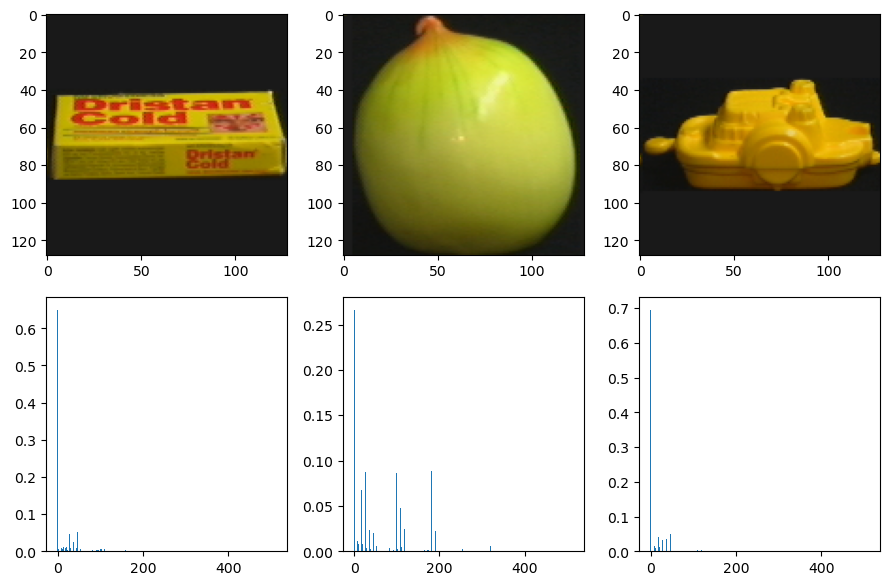

In [166]:
fig, axes = plt.subplots(nrows=2, ncols=len(test_images), figsize=(9, 6), dpi=100)
for i in range(len(test_images)):
    axes[0, i].imshow(test_images[i])
    axes[1, i].bar(range(test_histograms[i].size), height=test_histograms[i].reshape(-1), width=2)
plt.tight_layout()


In [167]:
num_hist = len(test_histograms)
for a in range(num_hist):
    for b in range(num_hist):
        print("L2(h{}, h{}) = {}".format(a+1, b+1, compare_histograms(test_histograms[a], test_histograms[b])))

L2(h1, h1) = 0.0
L2(h1, h2) = 0.42630332471992644
L2(h1, h3) = 0.09507866927455817
L2(h2, h1) = 0.42630332471992644
L2(h2, h2) = 0.0
L2(h2, h3) = 0.4773205294166603
L2(h3, h1) = 0.09507866927455817
L2(h3, h2) = 0.4773205294166603
L2(h3, h3) = 0.0


- The most similar image to image "object_01_1.png" is image "object_03_1.png" (distance ~ 0.1), it is of course most similar to itself (with distance 0) and the least similar to image "object_02_1.png" (distance ~ 0.43).
- All three histograms have a very expressed component for black color (and other more dark colors) on index (0, 0, 0), we can also see that this is because of the black background that the objects are infront of.

In [168]:
def directory_histograms(dir_path, bins=256):
    images = [cv2.cvtColor(cv2.imread(os.path.join(dir_path, filename)), cv2.COLOR_BGR2RGB) for filename in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, filename))]
    return [(img, myhist3(img, bins=bins)) for img in images]

In [169]:
dataset_dir_histograms = directory_histograms("./assigments/assigment2/dataset/", bins=8)

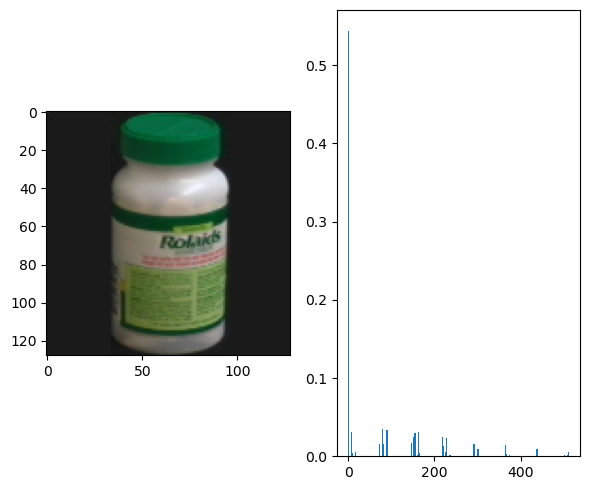

In [170]:
seed(100)
selected_image, selected_histogram = dataset_dir_histograms[randint(0, len(dataset_dir_histograms))]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 5), dpi=100)
axes[0].imshow(selected_image)
axes[1].bar(range(selected_histogram.size), height=selected_histogram.reshape(-1), width=3)
plt.tight_layout()

In [171]:
sorted_related_histograms = sorted([(compare_histograms(selected_histogram, ddh[1], metric=chi_square_distance), ddh[0], ddh[1]) for ddh in dataset_dir_histograms], key = lambda x:x[0])

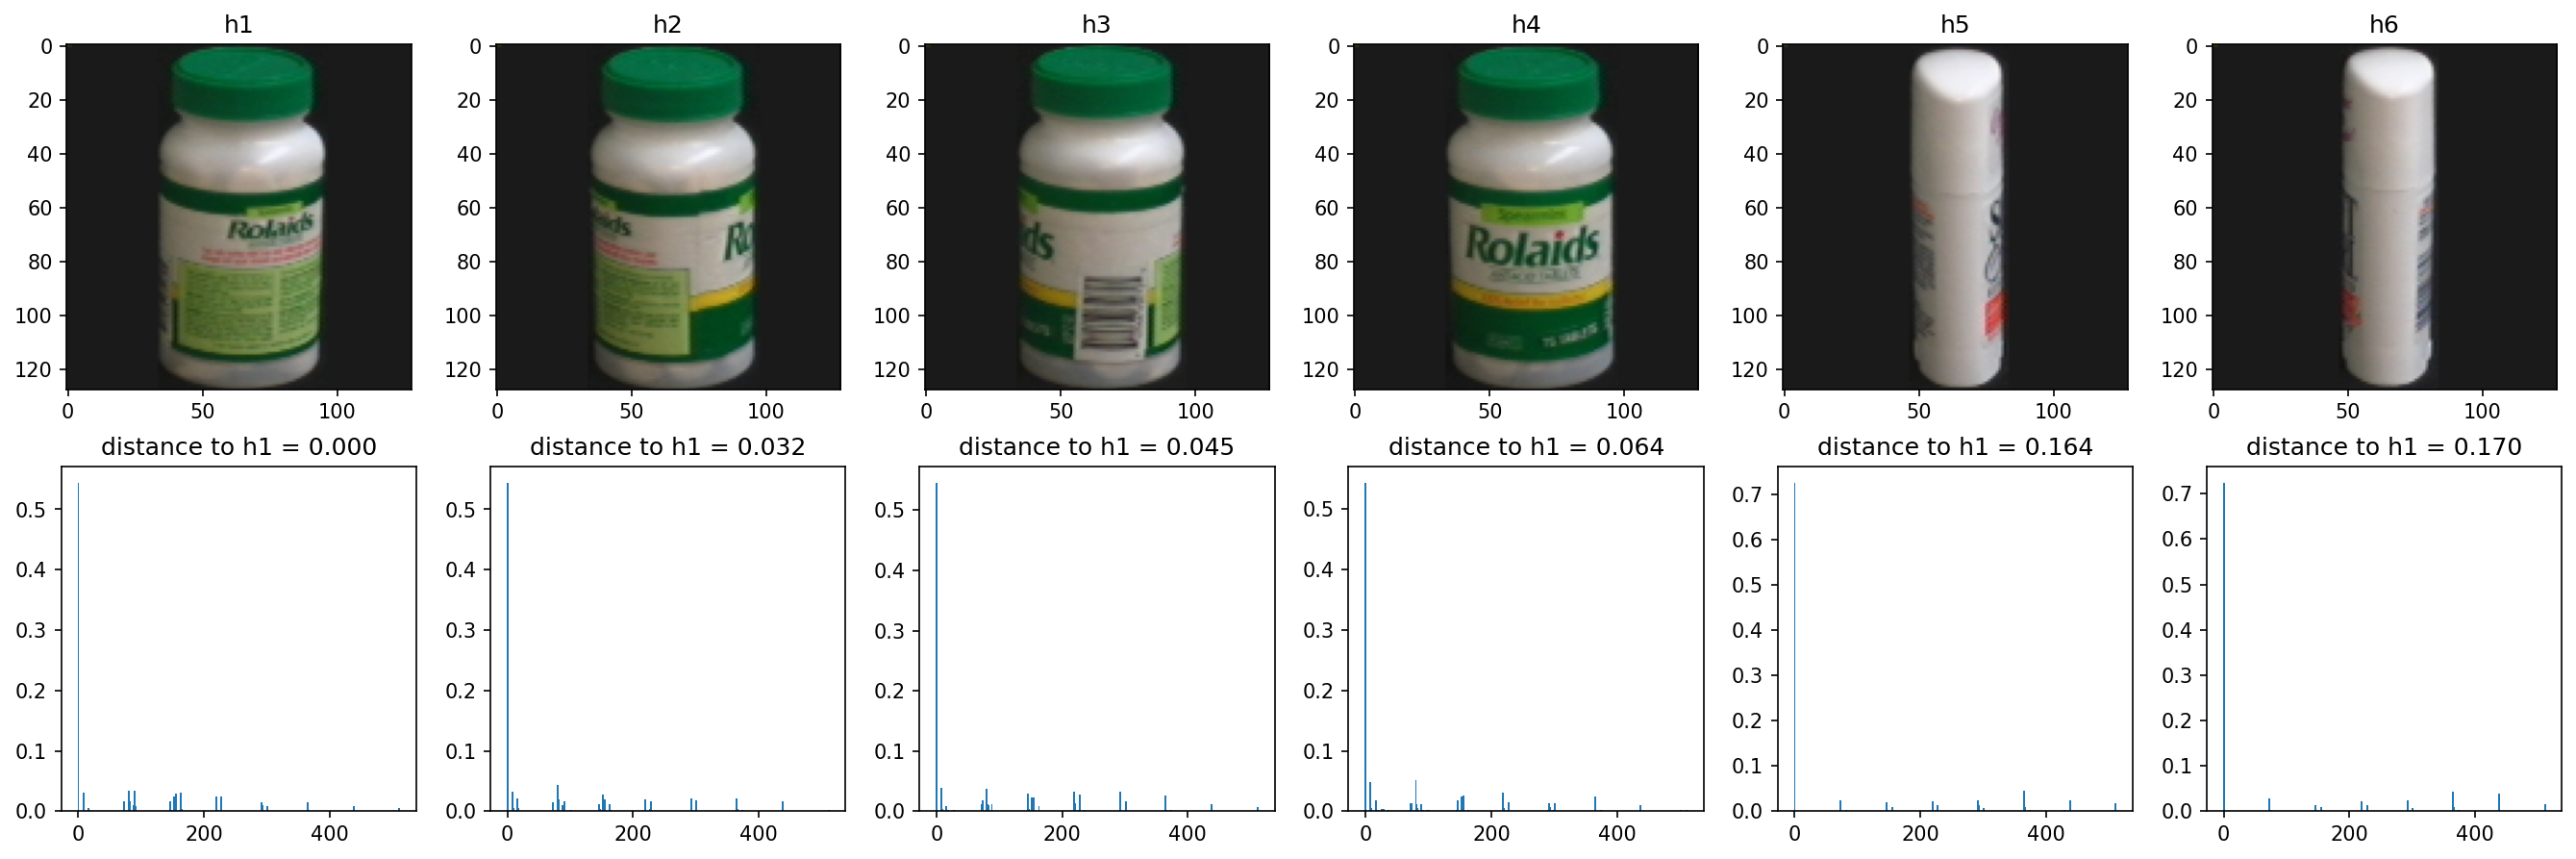

In [172]:
N_MOST_SIMILAR = 5
fig, axes = plt.subplots(nrows=2, ncols=N_MOST_SIMILAR + 1, figsize=(3 * (N_MOST_SIMILAR + 1), 3 * 2), dpi=150)
for i in range(N_MOST_SIMILAR + 1):
    axes[0, i].imshow(sorted_related_histograms[i][1])
    axes[0, i].set_title("h{}".format(i +1))
    axes[1, i].bar(range(sorted_related_histograms[i][2].size), height=sorted_related_histograms[i][2].reshape(-1), width=3)
    axes[1, i].set_title(f"distance to h1 = {sorted_related_histograms[i][0]:.3f}")
plt.tight_layout()

I would use chi_square_distance because it compares relative differences which helps when the images have large similar areas (in our examples a lot of images have dark/black background, and a lot of white/gray colors so chi_square_distance puts emphasis on smaller details - for example if an object is missing a red dot).

Otherwise the 2D euclidian distance or similar to it hellinger_distance would be also usefull in general (even using the combination of those and chi might be well suited for some situations).

In [173]:
distance_functions = [L2, chi_square_distance, intersection, hellinger_distance]
distances_by_function = [
    [compare_histograms(selected_histogram, ddh[1], metric=dst_func) for ddh in dataset_dir_histograms] for dst_func in distance_functions
]

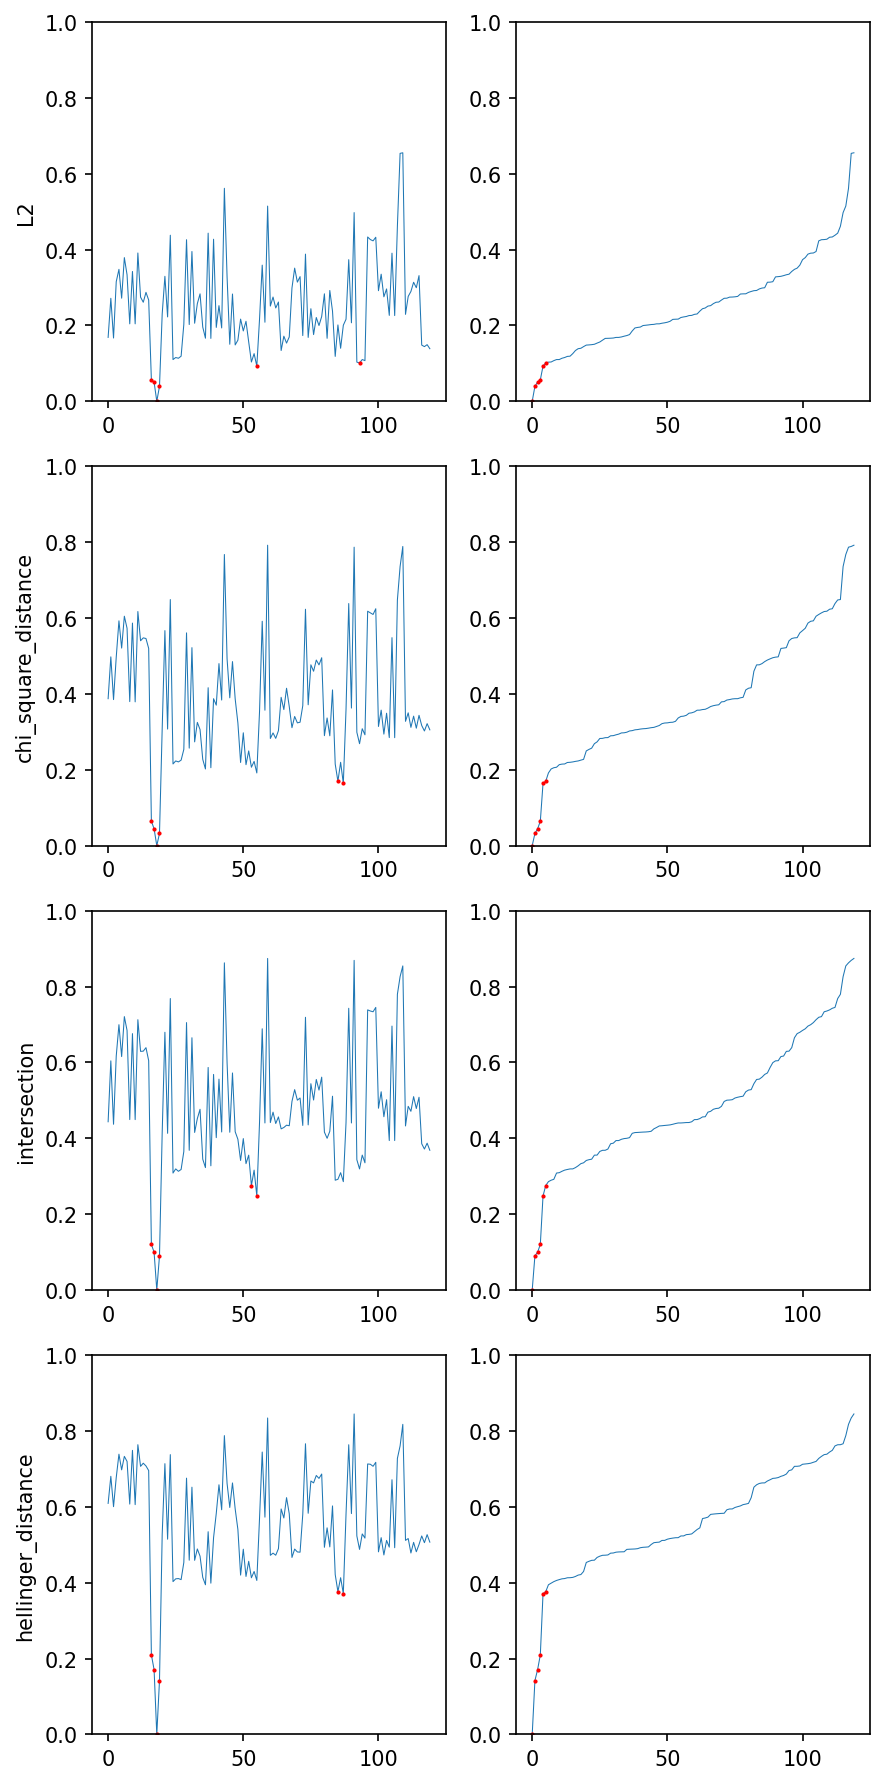

In [174]:
MARK_N_MOST_SIMILAR = 5
fig, axes = plt.subplots(nrows=len(distances_by_function), ncols=2, figsize=(6, 3 * len(distances_by_function)), dpi=150)
for i in range(len(distances_by_function)):
    sorted_distances = sorted(distances_by_function[i])
    y_limit = sorted_distances[MARK_N_MOST_SIMILAR +1]
    axes[i, 0].plot(range(len(distances_by_function[i])), distances_by_function[i], lw=0.5, marker='o', ms=1, mec='red', mfc='red', markevery=np.where(distances_by_function[i] < y_limit)[0], )
    axes[i, 1].plot(range(len(distances_by_function[i])), sorted_distances, lw=0.5, marker='o', ms=1, mec='red', mfc='red', markevery=np.where(sorted_distances < y_limit)[0])

    axes[i, 0].set_ylim((0, 1))
    axes[i, 0].set_ylabel(distance_functions[i].__name__)

    axes[i, 1].set_ylim((0, 1))
plt.tight_layout()

In [175]:
dataset_dir_histograms_only = [item[1] for item in dataset_dir_histograms]
summed_histograms = np.sum(dataset_dir_histograms_only, axis=0)

<BarContainer object of 512 artists>

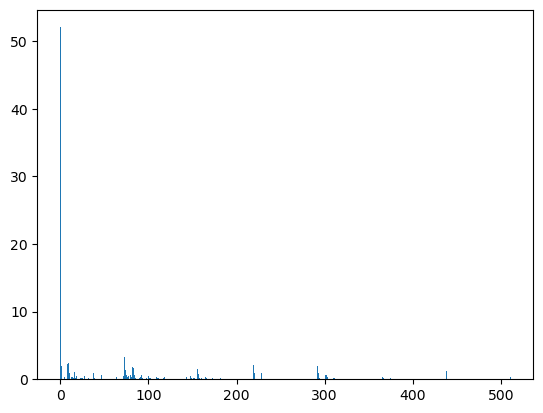

In [176]:
plt.bar(range(summed_histograms.size), summed_histograms.flat)

Histogram is dominated especially by bin 0, there are also more dominant bins around 80-90 and 220-240, 290-300

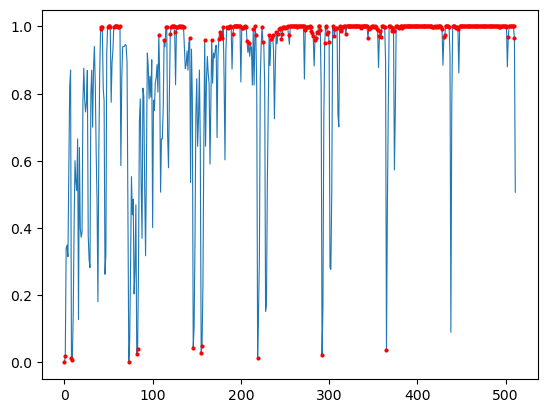

In [177]:
scale_constant = 2
scale_matrix = np.exp(-scale_constant * summed_histograms)

min_difference = 0.05
supressed_colors = np.where(scale_matrix.flat - scale_matrix.min() < min_difference)[0]
emphasised_colors = np.where(scale_matrix.max() - scale_matrix.flat  < min_difference)[0]
markers = np.concatenate((supressed_colors, emphasised_colors))

plt.plot(range(scale_matrix.size), scale_matrix.flat, markevery=markers, mfc='red', mec='red', marker='o', ms=2, lw=0.8)

In [178]:
def scale_and_compare(hist_A, hist_B, metric=L2, scaling_matrix=1):
    hist_A_scaled = hist_A * scale_matrix
    hist_B_scaled = hist_B * scale_matrix
    return compare_histograms(hist_A_scaled, hist_B_scaled, metric=metric)

In [179]:
sorted_scaled_related_histograms = sorted([(scale_and_compare(selected_histogram, ddh[1], metric=L2, scaling_matrix=scale_matrix), ddh[0], ddh[1]) for ddh in dataset_dir_histograms], key = lambda x:x[0])

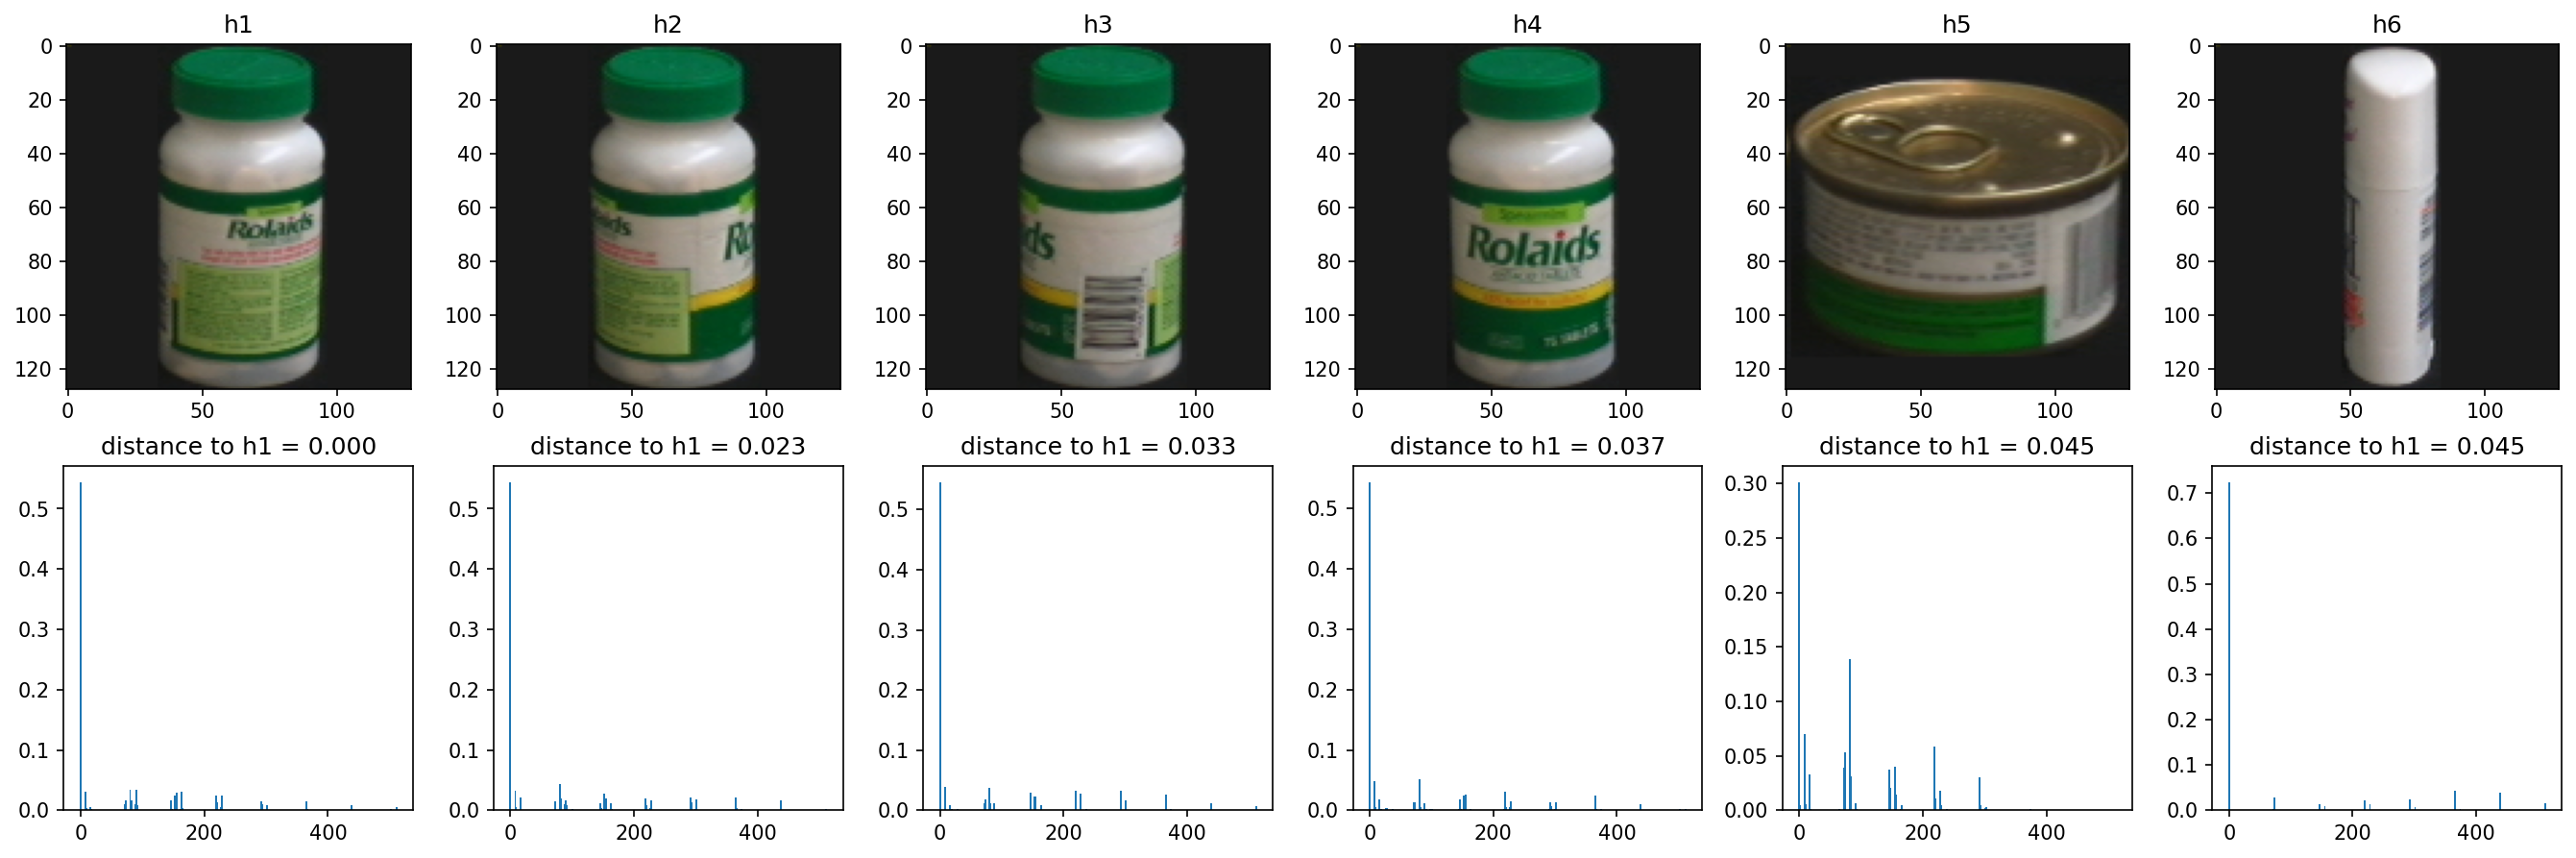

In [180]:
N_MOST_SIMILAR = 5
fig, axes = plt.subplots(nrows=2, ncols=N_MOST_SIMILAR + 1, figsize=(3 * (N_MOST_SIMILAR + 1), 3 * 2), dpi=150)
for i in range(N_MOST_SIMILAR + 1):
    axes[0, i].imshow(sorted_scaled_related_histograms[i][1])
    axes[0, i].set_title("h{}".format(i +1))
    axes[1, i].bar(range(sorted_scaled_related_histograms[i][2].size), height=sorted_scaled_related_histograms[i][2].reshape(-1), width=3)
    axes[1, i].set_title(f"distance to h1 = {sorted_scaled_related_histograms[i][0]:.3f}")
plt.tight_layout()

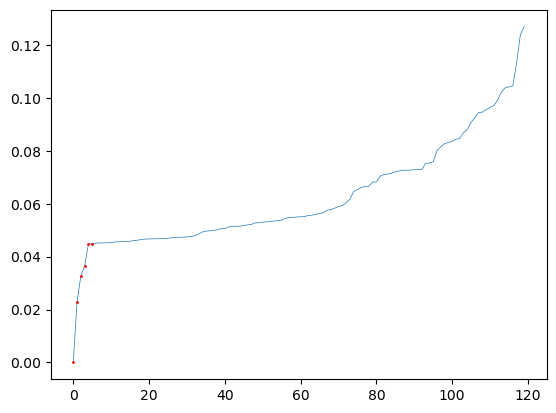

In [181]:
MARK_N_MOST_SIMILAR = 5
distance_by_image = [item[0] for item in sorted_scaled_related_histograms]
y_limit = distance_by_image[MARK_N_MOST_SIMILAR + 1]
plt.plot(range(len(distance_by_image)), distance_by_image, markevery=np.where(distance_by_image < y_limit)[0], mfc='red', mec='red', marker='o', ms=1, lw=0.5)

Scaled comparison produced similar results to unscaled but did slightly alter the graph slightly. Graph has a much steeper begining, meaning that the object similarity is further apart. I would assume that this is because larger regions (black, green) are not as important and in turn elements that were similar in this aspects but not in detail (because of rotation, missing colors etc) are pushed further apart.

If I increased the scaling constant, dark background was practically ignored and results became less dependedt on that aspect (we got some new results that have less background but are more similar in colors that are in general not as present in an average image).

## Exercise 2

In [182]:
from a2_utils import read_data as read_numpy_arr_from_txt
from math import ceil, sqrt, pi, exp

- f = [0, 1, 1, 1, 0, 0.7, 0.5, 0.2, 0, 0, 1, 0]
- k = [0.5, 1, 0.3]
- k * f = [1.3, 1.8, 1.5, 0.71, 0.85, 0.91, 0.45, 0.1. 0.3, 1]

In [183]:
def simple_convolution(I, k):
    k = np.array(k)
    N = int((len(k) - 1) / 2)
    convoluted_I = np.empty_like(I)
    for i in range(len(I)):
        if i < N or i >= len(I) - N:
            convoluted_I[i] = I[i]
            continue
        
        convoluted_I[i] = np.sum(I[i - N: i + N +1] * k)
    return convoluted_I

In [184]:
def less_simple_convolution(I, k,):
    k = np.array(k)
    N = int((len(k) - 1) / 2)
    convoluted_I = np.empty_like(I)
    for i in range(len(I)):
        # extract chunk of the signal
        signal_chunk = I[max(i - N, 0): i + N +1]
        # if needed adjust signal_chunk
        if len(signal_chunk) < len(k):
            signal_chunk = np.concatenate(([I[0] for _ in range(max(N - i, 0))], signal_chunk, [I[-1] for _ in range(max((i + N + 1) - len(I), 0))]))
        # compute convolution
        convoluted_I[i] = np.sum(signal_chunk * k)
    return convoluted_I

In [185]:
simple_convolution([0, 1, 1, 1, 0, 0.7, 0.5, 0.2, 0, 0, 1, 0], [0.5, 1, 0.3]) # check manual method (edges are excluded in manual method)

array([0.  , 1.3 , 1.8 , 1.5 , 0.71, 0.85, 0.91, 0.45, 0.1 , 0.3 , 1.  ,
       0.  ])

In [186]:
kernel = read_numpy_arr_from_txt("./assigments/assigment2/kernel.txt")
signal = read_numpy_arr_from_txt("./assigments/assigment2/signal.txt")

In [187]:
convoluted_signal = simple_convolution(signal, kernel)
convoluted_signal_task_c = less_simple_convolution(signal, kernel)
convoluted_signal_cv2 = cv2.filter2D(signal, kernel=kernel, ddepth=-1)

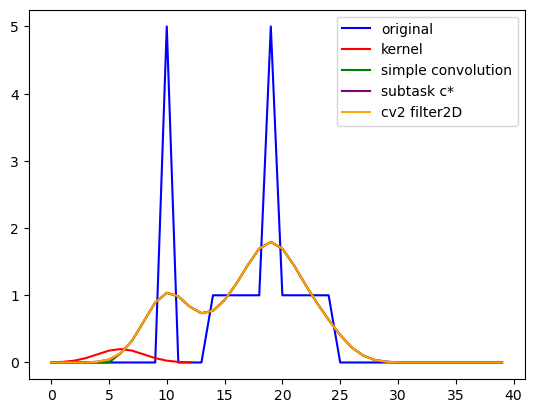

In [188]:
plt.plot(range(len(signal)), signal, label="original", color='blue')
plt.plot(range(len(kernel)), kernel, label="kernel", color='red')
plt.plot(range(len(convoluted_signal)), convoluted_signal, label="simple convolution", color='green')
plt.plot(range(len(convoluted_signal_task_c)), convoluted_signal_task_c, label="subtask c*", color='purple')
plt.plot(range(len(convoluted_signal_cv2)), convoluted_signal_cv2, label="cv2 filter2D", color='orange')
plt.legend()
# note on my graph open cv2 overlapps with my convolution since i don't exclude edge values in the signal but just leave them as is

Kernel looks like a very subtle gaussian filter commonly used for smoothing out noise and/or blurring the image.

In [189]:
def gaussian(x, o):
    return (sqrt(2*pi)*o)**(-1) * exp(- x**2 / (2*o**2))

def gaussian_kernel(o):
    bound = ceil(3 * o)
    kernel = np.empty(2 * bound + 1)
    kernel[bound] = gaussian(0, o)
    for x in range(1, bound + 1):
        val = gaussian(x, o)
        kernel[bound - x] = val
        kernel[bound + x] = val
    return kernel

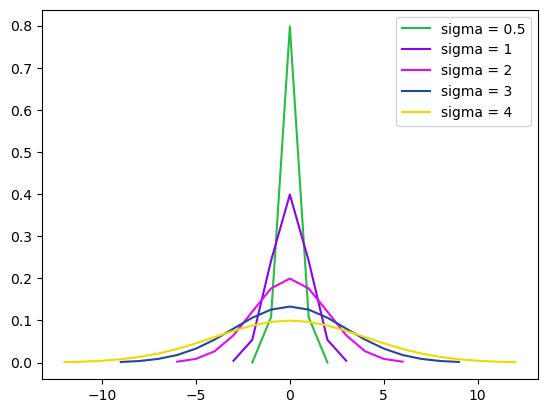

In [190]:
np.random.seed(12)
sigmas = [0.5, 1, 2, 3, 4]
kernels_for_sigmas = [gaussian_kernel(o) for o in sigmas]
for i, k in enumerate(kernels_for_sigmas):
    x_ticks_bound = int(len(k) / 2)
    plt.plot(range(-x_ticks_bound, x_ticks_bound +1), k, color=np.random.rand(3,), label = f'sigma = {sigmas[i]}')
plt.legend()

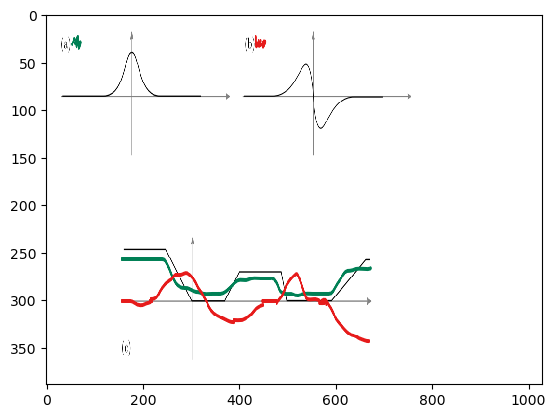

In [191]:
plt.imshow(cv2.cvtColor(cv2.imread("./assigments/assigment2/exercise2_d_sktech.png"), cv2.COLOR_BGR2RGB), interpolation='nearest', aspect='auto')

In [192]:
gk1 = gaussian_kernel(2)
k2 = [0.1, 0.6, 0.4]
k3 = less_simple_convolution(gk1, k2)

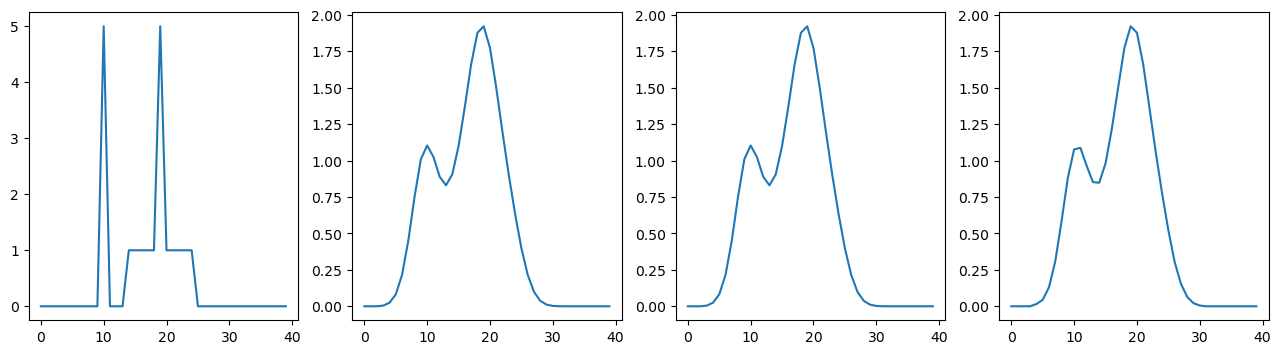

In [193]:
lsc = less_simple_convolution
signals = [signal, lsc(lsc(signal, gk1), k2), lsc(lsc(signal, k2), gk1), lsc(signal, k3)]

fig, axes = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(16, 4)
for i, s in enumerate(signals):
    axes[i].plot(range(len(s)), s)

Different order of operations has no effect on the final result, we need to note that using more kernels with specific edge padding methods might alter the edges differently.

## Exercise 3

In [205]:
from a2_utils import gauss_noise, sp_noise

In [195]:
def gaussfilter(I, o=1):
    kernel = gaussian_kernel(o)
    c_I = cv2.filter2D(I, ddepth=-1, kernel=kernel)
    c_I = cv2.filter2D(c_I, ddepth=-1, kernel=kernel.T)
    return c_I

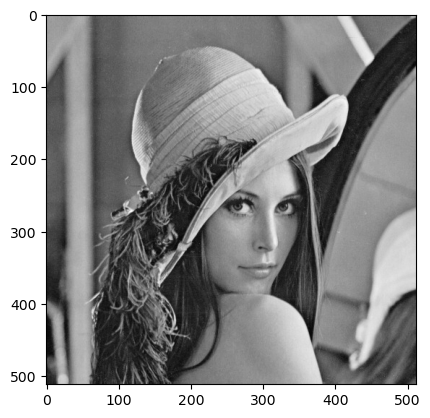

In [196]:
lena = cv2.imread("./assigments/assigment2/images/lena.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(lena, cmap="gray")

In [197]:
lena_gaussian_noise = gauss_noise(lena, magnitude=10)
lena_salt_and_peper = sp_noise(lena, percent=0.1)

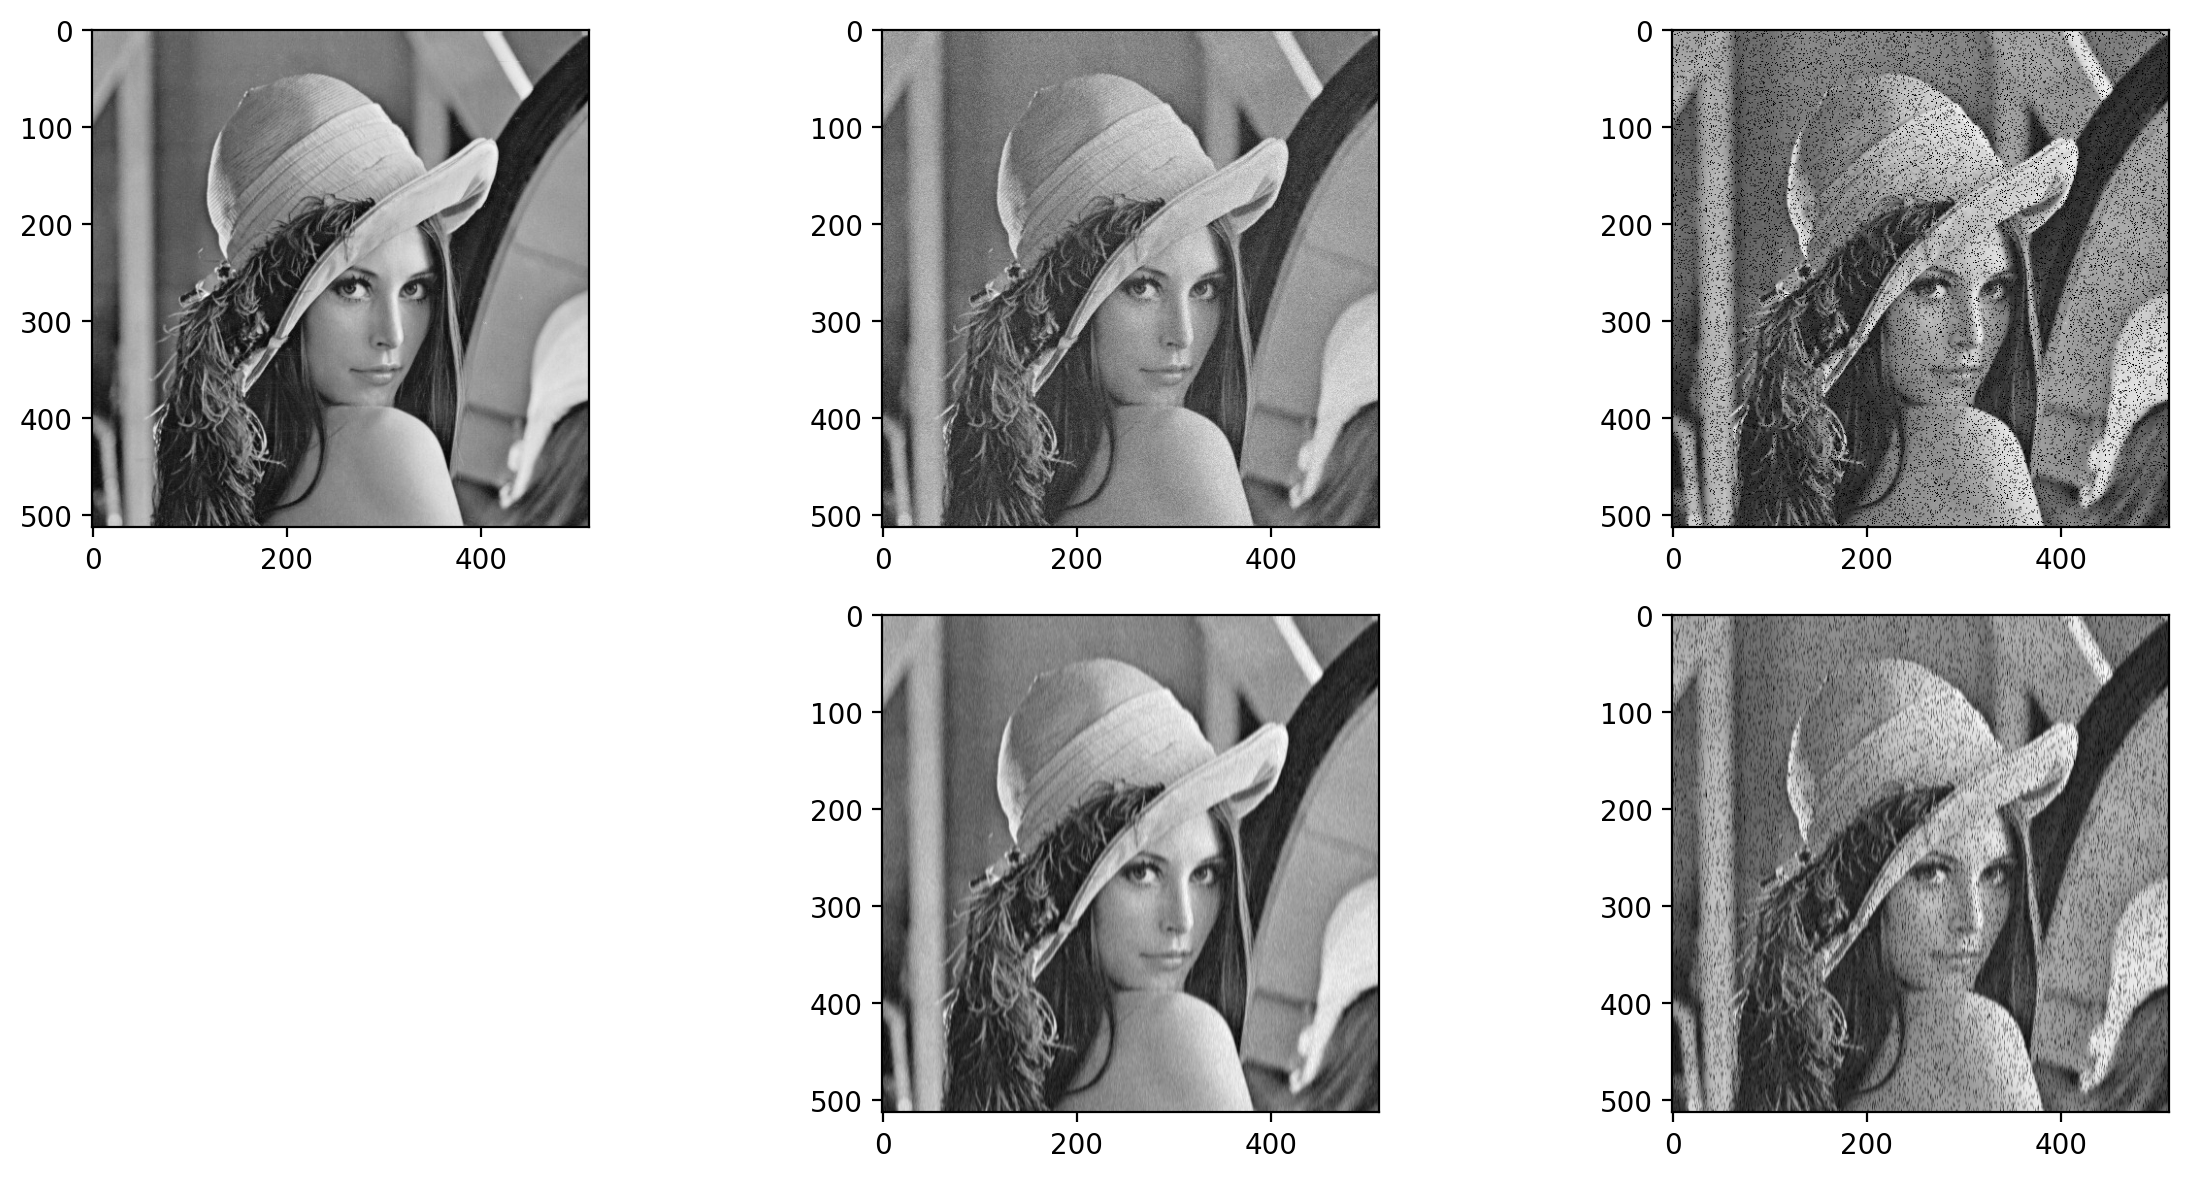

In [198]:
filter_intensity = 1
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(12, 6)
fig.set_dpi(200)
axes[0, 0].imshow(lena, cmap='gray')
axes[0, 1].imshow(lena_gaussian_noise, cmap='gray')
axes[0, 2].imshow(lena_salt_and_peper, cmap='gray')
axes[1, 1].imshow(gaussfilter(lena_gaussian_noise, filter_intensity), cmap='gray')
axes[1, 2].imshow(gaussfilter(lena_salt_and_peper, filter_intensity), cmap='gray')
axes[1, 0].remove()
plt.tight_layout()

Gaussian filter better reduces gaussian noise.

In [199]:
sf = 0 - 1/9
ef = 2 - 1/9
sharpening_filter = np.array([
    [sf, sf, sf],
    [sf, ef, sf],
    [sf, sf, sf]
])

In [200]:
museum = cv2.imread("./assigments/assigment2/images/museum.jpg", cv2.IMREAD_GRAYSCALE)
museum_sharpened_correlation = cv2.filter2D(museum, ddepth=-1, kernel=sharpening_filter)
museum_sharpened_convolution = cv2.filter2D(museum_sharpened_correlation, ddepth=-1, kernel=sharpening_filter.T)

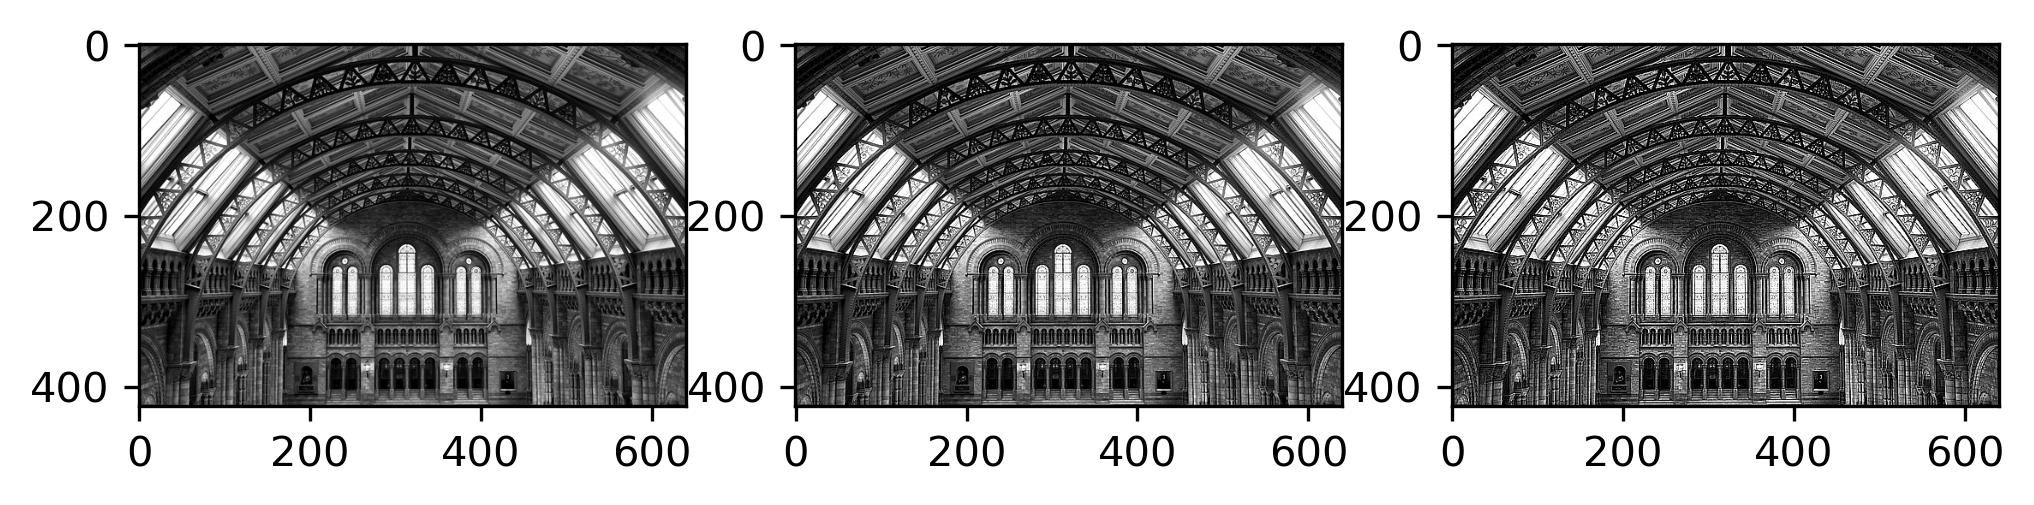

In [201]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(8, 4)
fig.set_dpi(300)
axes[0].imshow(museum, cmap='gray')
axes[1].imshow(museum_sharpened_correlation, cmap='gray')
axes[2].imshow(museum_sharpened_convolution, cmap='gray')

In [246]:
def simple_median_1d(I, w):
    I_f = np.empty_like(I)
    size = len(I)
    for i in range(size):
        x_l = max(i - w, 0)
        x_r = min(i + w, size)
        I_f[i] = np.median(I[x_l:x_r])
    return I_f

def simple_median_2d(I, w):
    I_f = np.empty_like(I)
    rows, cols = I.shape
    for i in range(rows):
        for j in range(cols):
            x_l = max(j - w, 0)
            x_r = min(j + w, cols)
            y_b = max(i - w, 0)
            y_t = min(i + w, rows)
            I_f[i, j] = np.median(I[y_b:y_t, x_l:x_r])
    return I_f

In [232]:
signal = np.zeros(40)
signal[10:20] = 1

np.random.seed(1000)
percent = 0.2
corrupted_signal = signal.copy()
corrupted_signal[np.random.random(len(signal)) < percent / 2] = 1
corrupted_signal[np.random.random(len(signal)) < percent / 2] = 0

corrected_signal_gauss = cv2.filter2D(corrupted_signal, ddepth=-1, kernel=gaussian_kernel(3))
corrected_signal_median = simple_median_1d(corrupted_signal, 5)

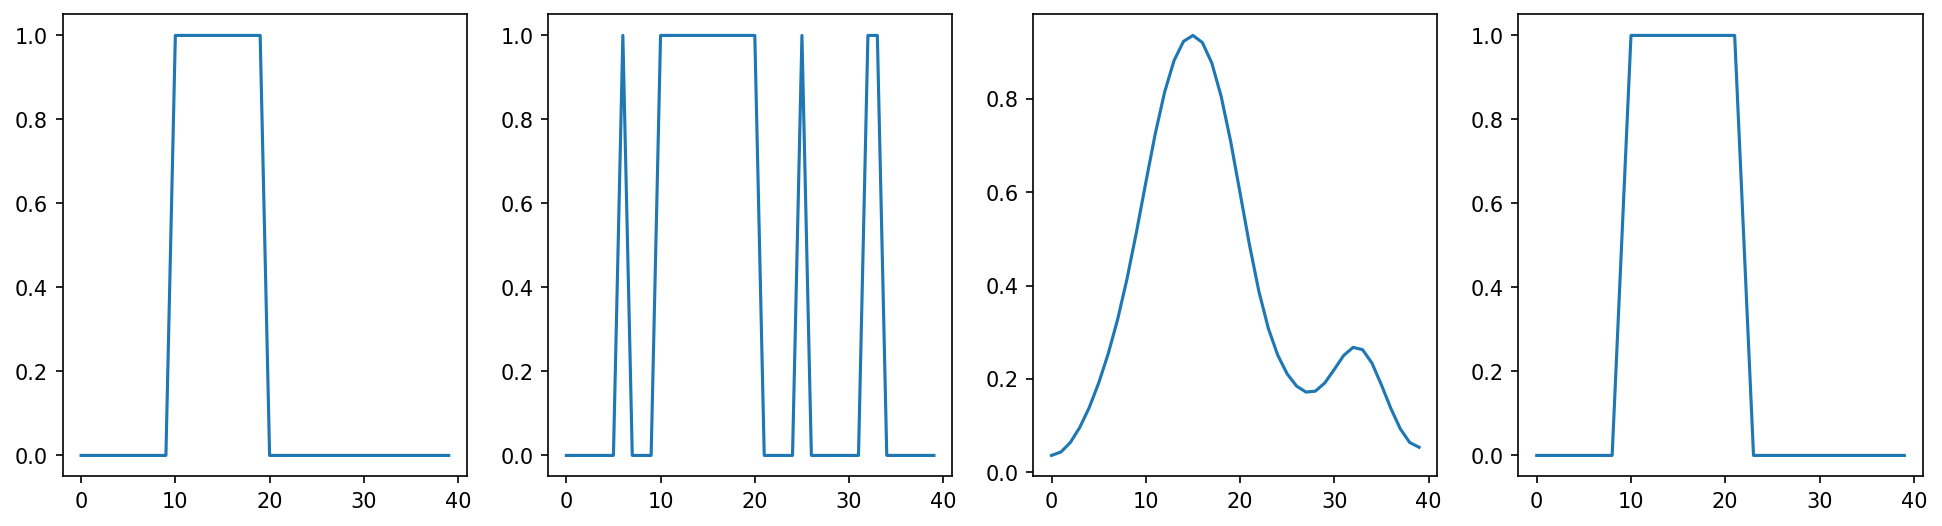

In [233]:
fig, axes = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(16, 4)
fig.set_dpi(150)

axes[0].plot(signal)
axes[1].plot(corrupted_signal)
axes[2].plot(corrected_signal_gauss)
axes[3].plot(corrected_signal_median)

Median filter preforms better. Yes the order matters. This kind of filters are called ____.

In [248]:
lena_gn_gf = gaussfilter(lena_gaussian_noise)
lena_spn_gf = gaussfilter(lena_salt_and_peper)

In [249]:
lena_gn_mf = simple_median_2d(lena_gaussian_noise, 1)
lena_spn_mf = simple_median_2d(lena_salt_and_peper, 1)

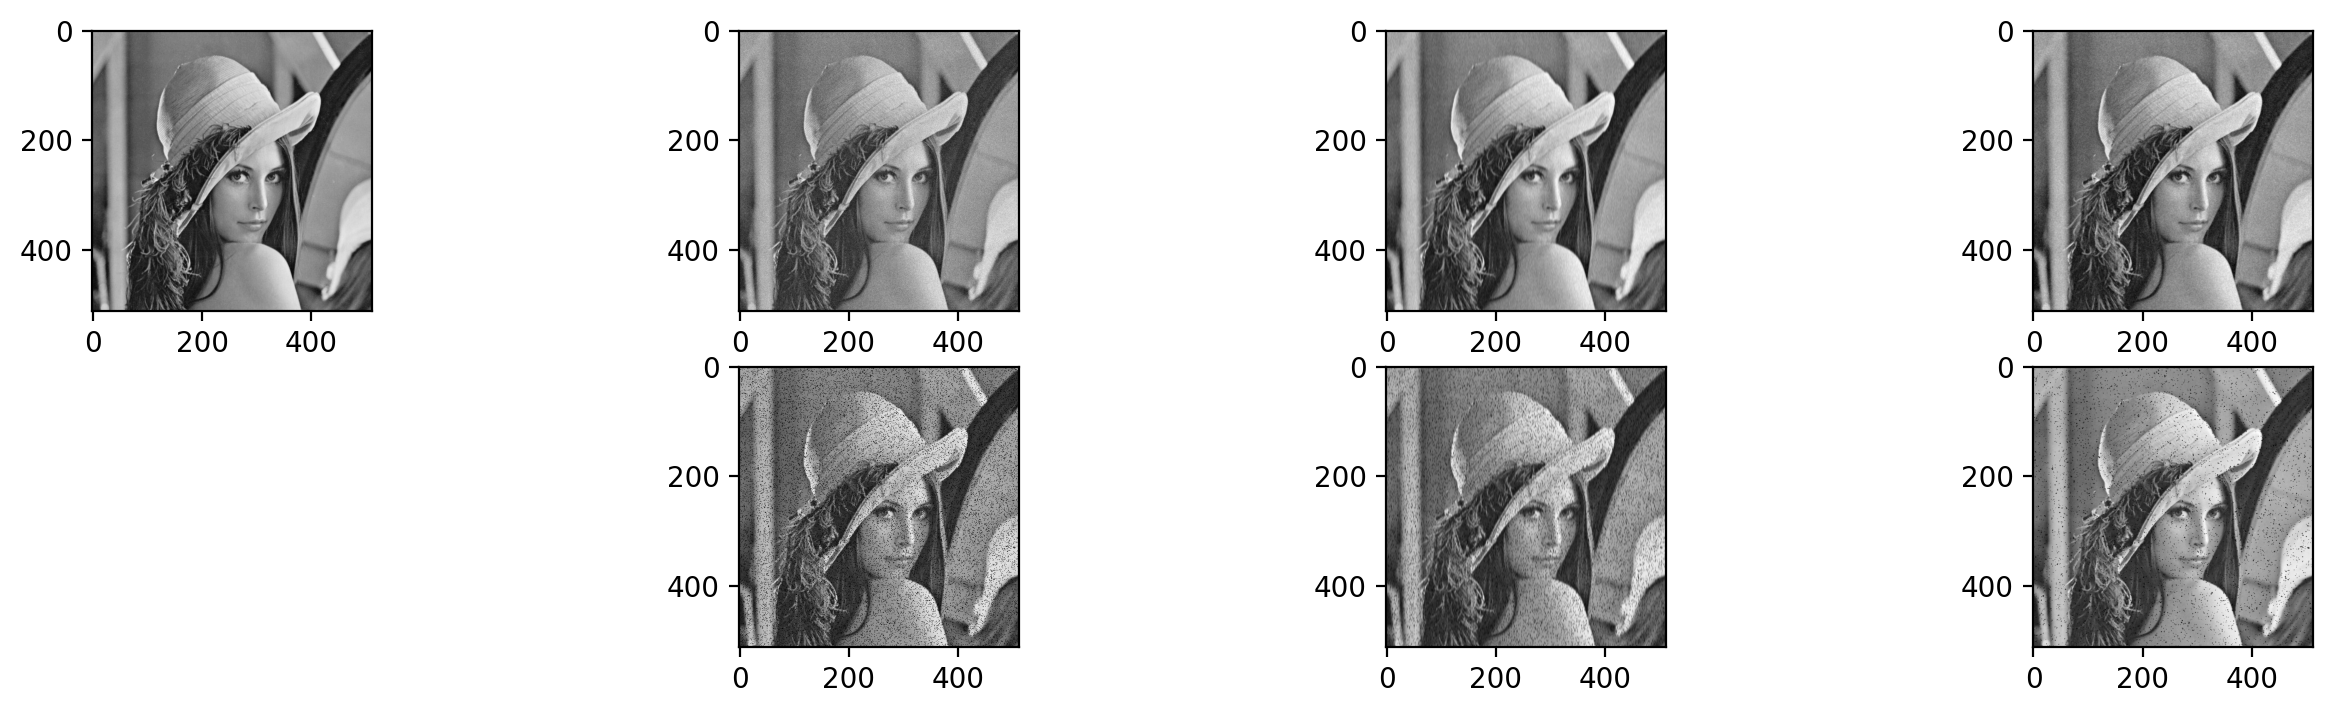

In [252]:
fig, axes = plt.subplots(nrows=2, ncols=4)
fig.set_size_inches(16, 4)
fig.set_dpi(200)
axes[0, 0].imshow(lena, cmap='gray')

axes[0, 1].imshow(lena_gaussian_noise, cmap='gray')
axes[1, 1].imshow(lena_salt_and_peper, cmap='gray')

axes[0, 2].imshow(lena_gn_gf, cmap='gray')
axes[1, 2].imshow(lena_spn_gf, cmap='gray')

axes[0, 3].imshow(lena_gn_mf, cmap='gray')
axes[1, 3].imshow(lena_spn_mf, cmap='gray')

axes[1, 0].remove()

filter2D can use FFT on frequency domain of the signal can have improved time complexity up to O(n * log(n)). So as long as our filter is small this will be dominant time complexity.

Median filter has 0(n^2 * m * log(m)) time complexity since it can't operate on frequency domain but uses discrete data and needs to iterate over all pixels and compute medians in 0(m * log(m)) time. (it depends greatly on the width of the filter, and of course source size).